# Case study: Reed breast leukocyte data

This notebook generates results for a case study that uses a [Human Breast Cell Atlas dataset](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637).

This is an example where we use the Extended Neighbourhood-Proportion-Error (xNPE) to compare embedding distortion of different cell populations, as well as neighbourhood composition plots to reveal sources of distortion.

<hr>

## **0.** Load required modules

In addition to `ViVAE`, `ViScore` and their dependenceis, you will need to have `umap` installed in your conda environment.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import ViVAE
import ViScore
from sklearn.manifold import TSNE
from umap import UMAP
import torch

## **1.** Load input data

See the ViScore [benchmarking](https://github.com/saeyslab/ViScore/tree/main/benchmarking) page for instructions on how to obtain and pre-process the Reed data.

In [2]:
## Load input data

dataset = 'Reed'

pc    = np.load(os.path.join('..', 'data', f'{dataset}_input.npy'),          allow_pickle=True)
pc_d  = np.load(os.path.join('..', 'data', f'{dataset}_input_denoised.npy'), allow_pickle=True)
labs  = np.load(os.path.join('..', 'data', f'{dataset}_labels.npy'),         allow_pickle=True)
unass = np.load(os.path.join('..', 'data', f'{dataset}_unassigned.npy'),     allow_pickle=True).item()

We will also generate (or load) a *k*-nearest-neighbour graph for 1000 neighbours, to use for the xNPE computation.

In [3]:
knn1000 = ViScore.make_knn(pc, fname=os.path.join('..', 'data', f'{dataset}_knn1000.npy'), k=1000, random_state=42)

Loading k-NNG


## **2.** Generating embeddings

We use *t*-SNE, UMAP and ViVAE to generate embeddings of this dataset.
We use default hyperparameter values, with denoising for *ViVAE*.
(See our paper for ablation studies about denoising.)

We use the `random_state` argument in model constructors, and manual seeds for `numpy` and `torch`.
This should achieve reproducibility across runs on a single machine (with the same GPU/CPU device for *ViVAE*).
If complete reproducibility (*ie.*, identical results) is not achieved with *ViVAE*, consult [this document](https://pytorch.org/docs/stable/notes/randomness.html) for troubleshooting.

In [4]:
## Train t-SNE model & transform inputs

model_tsne = TSNE(n_components=2, random_state=1)
emb_tsne = model_tsne.fit_transform(pc)

In [5]:
## Train UMAP model & transform inputs

model_umap = UMAP(n_components=2, random_state=1)
emb_umap = model_umap.fit_transform(pc)

In [6]:
## Train ViVAE model & transform inputs

np.random.seed(1)
torch.manual_seed(1)
model_vivae = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=1)
model_vivae.fit(pc_d)
emb_vivae = model_vivae.transform(pc_d)

Epoch 1/50	recon: 112.6770	kldiv: 2.4128	geom: 0.0000	egeom: 0.0000	mds: 1384.6440
Epoch 2/50	recon: 28.4697	kldiv: 2.1946	geom: 0.0000	egeom: 0.0000	mds: 327.8572
Epoch 3/50	recon: 15.4869	kldiv: 1.5297	geom: 0.0000	egeom: 0.0000	mds: 203.6849
Epoch 4/50	recon: 10.6089	kldiv: 1.1287	geom: 0.0000	egeom: 0.0000	mds: 145.7187
Epoch 5/50	recon: 8.0254	kldiv: 0.8658	geom: 0.0000	egeom: 0.0000	mds: 111.4248
Epoch 6/50	recon: 6.3843	kldiv: 0.9492	geom: 0.0000	egeom: 0.0000	mds: 62.8819
Epoch 7/50	recon: 4.9425	kldiv: 0.9579	geom: 0.0000	egeom: 0.0000	mds: 42.1714
Epoch 8/50	recon: 3.8140	kldiv: 0.8453	geom: 0.0000	egeom: 0.0000	mds: 34.9478
Epoch 9/50	recon: 2.9419	kldiv: 0.7522	geom: 0.0000	egeom: 0.0000	mds: 30.5181
Epoch 10/50	recon: 2.4755	kldiv: 0.6744	geom: 0.0000	egeom: 0.0000	mds: 27.1771
Epoch 11/50	recon: 2.1820	kldiv: 0.5839	geom: 0.0000	egeom: 0.0000	mds: 23.9667
Epoch 12/50	recon: 1.9194	kldiv: 0.5256	geom: 0.0000	egeom: 0.0000	mds: 21.0710
Epoch 13/50	recon: 1.7070	kldiv: 0.492

In [7]:
## Save generated embeddings

np.save('emb_tsne.npy', emb_tsne, allow_pickle=True)
np.save('emb_umap.npy', emb_umap, allow_pickle=True)
np.save('emb_vivae.npy', emb_vivae, allow_pickle=True)

## **3.** Compute population-level xNPE scores

We use xNPE scoring to quantify misembedding of labelled cell populations using the 1000-nearest-neighbour graph built earlier.

In [8]:
## Compute xNPE

xnpe_tsne  = ViScore.xnpe(hd=pc, ld=emb_tsne,  annot=labs, knn=knn1000, random_state=42)
xnpe_umap  = ViScore.xnpe(hd=pc, ld=emb_umap,  annot=labs, knn=knn1000, random_state=42)
xnpe_vivae = ViScore.xnpe(hd=pc, ld=emb_vivae, annot=labs, knn=knn1000, random_state=42)

In [9]:
## Save xNPE results

np.save('xnpe_tsne.npy',  xnpe_tsne, allow_pickle=True)
np.save('xnpe_umap.npy',  xnpe_umap, allow_pickle=True)
np.save('xnpe_vivae.npy', xnpe_vivae, allow_pickle=True)

## **4.** Plot generated embeddings

Using a palette or more-or-less distinctive colours, we plot the 2-d layouts of the data that we obtained from the three methods.

In [10]:
palette = {
    'CD4-positive helper T cell':                           'sandybrown',
    'CD8-positive, alpha-beta memory T cell':               '#c1c86c',
    'Tc1 cell':                                             '#699dc0',
    'class switched memory B cell':                         '#d889c1',
    'dendritic cell':                                       '#a89ef4',
    'effector memory CD8-positive, alpha-beta T cell':      'firebrick',
    'innate lymphoid cell':                                 '#757469',
    'macrophage':                                           'olive',
    'mature NK T cell':                                     '#87d7d6',
    'naive B cell':                                         '#6afd6e',
    'naive thymus-derived CD4-positive, alpha-beta T cell': 'rebeccapurple',
    'natural killer cell':                                  'chocolate',
    'plasma cell':                                          'black',
    'unknown':                                              '#74c7c0',
    'unswitched memory B cell':                             'goldenrod' 
}

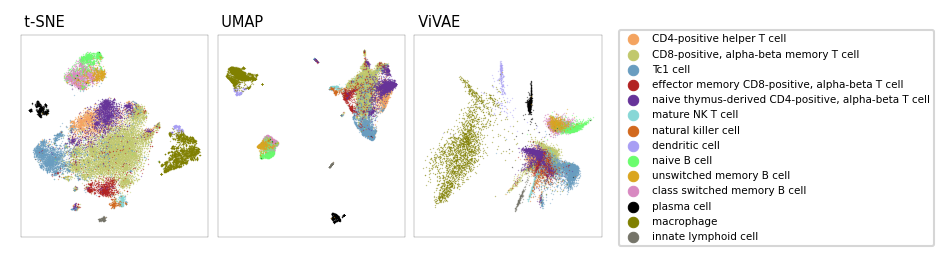

In [11]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = list(xnpe_tsne.keys())
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_vivae]
s = .01
for i, method in enumerate(methods):
        idcs0 = np.where(labs==unass)[0]
        idcs1 = np.delete(np.arange(len(labs)), idcs0)
        emb = embs[i]
        ax[i].scatter(emb[idcs0,0], emb[idcs0,1], s=s, c='#bfbfbf', alpha=1., linewidths=0)
        idx_pop = 0
        l = np.delete(labs, idcs0)
        for pop in np.unique(l):
            idcs = np.where(l == pop)[0]
            if i==(len(methods)-1):
                ax[i].scatter(emb[idcs1[idcs],0], emb[idcs1[idcs],1], label=pop, s=s, c=palette[pop], alpha=1., linewidth=.5)
            else:
                ax[i].scatter(emb[idcs1[idcs],0], emb[idcs1[idcs],1], s=s, c=palette[pop], alpha=1., linewidth=.5)
            ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
            idx_pop += 1
        ax[i].axis('equal')
        ax[i].set_title(f'  {methods[i]}', size=7, ha='left', x=-.03, y=.98)
        if i==(len(methods)-1):
            # Re-order points in legend to make them more sensible (ad hoc!)
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [0,1,2,5,10,8,11,4,9,13,3,12,7,6]
            
            fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.35, .92), fontsize=5, markerscale=50.)

fig.savefig('Reed_A_embeddings.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('Reed_A_embeddings.svg', bbox_inches='tight', transparent=True)

## **5.** Plot xNPE and neighoburhood compositions

Next, we generate diagnostic plots.
We pick a population of interest (`poi`: `'natural killer cell`), highlight it in the embeddings, show xNPE values for it and all other populations (for the three different methods) and create neighbourhood composition plots that show sources of embedding error for this POI.

In [12]:
## Set population of interest (POI)

poi = 'natural killer cell'

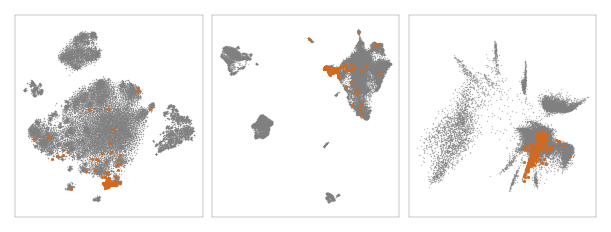

In [13]:
## Highlight the POI in 2-d layouts

mpl.rcParams['axes.linewidth'] = 0.1
pops = list(xnpe_tsne.keys())
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_vivae]
s = .01

idcs_nk = np.where(labs==poi)[0]
for i, method in enumerate(methods):

        emb = embs[i]
        ax[i].scatter(emb[:,0], emb[:,1], s=s, c='grey', alpha=1., linewidth=.5)
        ax[i].scatter(emb[idcs_nk,0], emb[idcs_nk,1], s=1., c=palette[poi], alpha=1., linewidth=.5)

        ax[i].axis('equal')
        ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
fig.savefig('reed_B_embeddings_poi.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('reed_B_embeddings_poi.svg', bbox_inches='tight', transparent=True)

In [14]:
## Aggregate xNPE values for all populations for all 3 embeddings

pops = list(xnpe_tsne.keys())
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
d = pd.DataFrame(
    data=np.vstack([list(xnpe_tsne.values()), list(xnpe_umap.values()), list(xnpe_vivae.values())]),
    columns=pops
)
d.index = methods
d = d.drop(unass, axis=1)
pops = list(d.keys())
npop = len(pops)

In [15]:
d

,CD4-positive helper T cell,"CD8-positive, alpha-beta memory T cell",Tc1 cell,class switched memory B cell,dendritic cell,"effector memory CD8-positive, alpha-beta T cell",innate lymphoid cell,macrophage,mature NK T cell,naive B cell,"naive thymus-derived CD4-positive, alpha-beta T cell",natural killer cell,plasma cell,unswitched memory B cell
t-SNE,0.745042,0.113528,0.275006,0.078988,0.262222,1.086664,0.205416,0.089813,0.609355,0.390412,0.431825,0.841634,0.176227,0.264530
UMAP,0.777875,0.095052,0.300218,0.051321,0.227085,0.841580,0.169475,0.117619,0.535983,0.272014,0.466090,0.795999,0.175825,0.265866
ViVAE,0.108728,0.152057,0.211642,0.143898,0.077705,0.439055,0.164109,0.079267,0.417294,0.270207,0.290985,0.387343,0.148446,0.188900


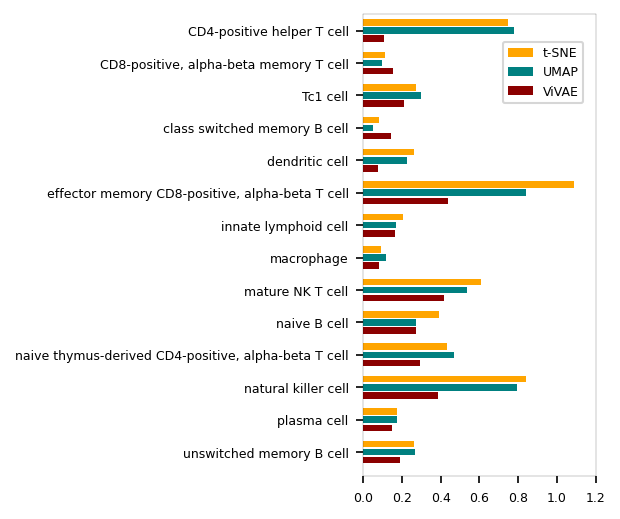

In [16]:
## Plot the xNPE values using a barplot

fig, ax = plt.subplots(figsize=(2,4), dpi=150)
mpl.rcParams['axes.linewidth'] = 0.1
pal = ['orange', 'teal', 'darkred']
n = npop*(nmet+1)

for i, method in enumerate(methods):
    for j, pop in enumerate(pops):
        if j==0:
            ax.barh(y=j*(nmet+1)+i, width=d[pop][method], color=pal[i], label=method)
        else:
            ax.barh(y=j*(nmet+1)+i, width=d[pop][method], color=pal[i])
ax.set_xlim((0., 1.2))
ax.set_ylim((-1, n))
pop_labels = copy.deepcopy(pops)
ax.set_yticks(ticks=np.arange(npop)*(nmet+1)+1, labels=pop_labels)
ax.tick_params(axis='both', labelsize=6)
plt.gca().invert_yaxis()

fig.legend(bbox_to_anchor=(.88, .845), fontsize=6)
fig.savefig('reed_C_barplot.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('reed_C_barplot.svg', bbox_inches='tight', transparent=True)

In [17]:
## Calculate neighbourhood compositions per population per embedding

pop      = poi
nc_hd    = ViScore.neighbourhood_composition(X=pc, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_tsne  = ViScore.neighbourhood_composition(X=emb_tsne, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_umap  = ViScore.neighbourhood_composition(X=emb_umap, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_vivae = ViScore.neighbourhood_composition(X=emb_vivae, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)

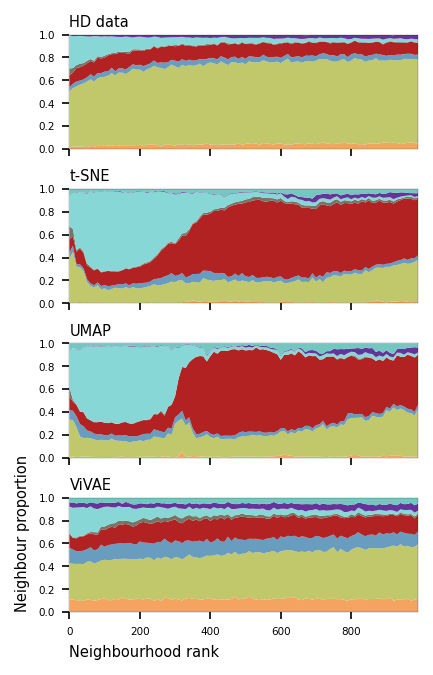

In [18]:
## Plot neighbourhood compositions

palette_without_poi = np.array(list(palette.values()))[np.where([x!=pop for x in list(palette.keys())])[0]]

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 5), dpi=150, sharey=True, sharex=True)
mpl.rcParams['axes.linewidth'] = 0.1
fig.subplots_adjust(hspace=.35)

for i, nc in enumerate([nc_hd, nc_tsne, nc_umap, nc_vivae]):
    y = np.vstack(nc[3])
    ax[i].stackplot(nc[4], y.T, labels=nc[1], colors=palette_without_poi)
    ax[i].set_ylim((0.,1.))
    ax[i].set_xlim((min(nc[4]), max(nc[4])))
    ax[i].set_title(['HD data', 't-SNE', 'UMAP', 'ViVAE'][i], size=7, ha='left', x=.0, y=.96)
    ax[i].tick_params(axis='both', labelsize=5)

ax[3].set_ylabel('Neighbour proportion', loc='bottom', size=7)
ax[3].set_xlabel('Neighbourhood rank', loc='left', size=7)

fig.savefig('reed_D_ncp.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('reed_D_npc.svg', bbox_inches='tight', transparent=True)